### Import Packages

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

from itertools import product
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)
from copy import deepcopy


import sys
sys.path.append('../src')
from utils import TimeStepSplit, plot_classification_results

### Load Data

In [2]:
df_node = pd.read_csv('../data/processed/node_data.csv')
df_edge = pd.read_csv('../data/processed/edge_data.csv')

display(df_node, df_edge)

,txId,class,timeStep,localF0,localF1,localF2,localF3,localF4,localF5,localF6,...,aggregatedF61,aggregatedF62,aggregatedF63,aggregatedF64,aggregatedF65,aggregatedF66,aggregatedF67,aggregatedF68,aggregatedF69,aggregatedF70
0,0,2,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,1,2,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,3,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,4,2,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,203764,2,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,203765,2,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,203766,1,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,203767,2,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


,txId1,txId2
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
...,...,...
234350,203602,201430
234351,203603,203099
234352,201921,202042
234353,201480,201368


### Train Test Split

In [ ]:
# Train/test mask
train_known_mask = torch.tensor((df_node['timeStep'] <= 35) & (df_node['class'] != 2), dtype=torch.bool)
test_known_mask = torch.tensor((df_node['timeStep'] > 35) & (df_node['class'] != 2), dtype=torch.bool)

### Features & Edges

In [4]:
# node features
local_features = [col for col in df_node.columns if col.startswith('localF')]

# edge_index
edge_index = torch.tensor(df_edge.values.T, dtype=torch.long)

### Helper Functions

In [ ]:
def train(model, data, optimizer, criterion, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def find_best_threshold(y_true, y_probs):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_threshold = 0.5
    best_f1 = 0
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    return best_threshold, best_f1

def evaluate(model, data, eval_mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        prob = F.softmax(out, dim=1)
        y_true = data.y[eval_mask].cpu().numpy()
        y_prob = prob[eval_mask][:, 1].cpu().numpy()
        best_threshold, best_f1 = find_best_threshold(y_true, y_prob)
        y_pred = (y_prob >= best_threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_prob)
    return {
        'f1': best_f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'threshold': best_threshold
    }

In [ ]:
# Soft Decision Tree
class SoftDecisionTree(nn.Module):
    def __init__(self, input_dim, num_classes, depth=3):
        super(SoftDecisionTree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth

        self.internal_nodes = nn.ModuleList([
            nn.Linear(input_dim, 1) for _ in range(self.num_leaves - 1)
        ])

        self.leaf_distributions = nn.Parameter(torch.randn(self.num_leaves, num_classes))

    def forward(self, x):
        batch_size = x.size(0)
        decisions = []
        for node in self.internal_nodes:
            decision = torch.sigmoid(node(x))
            decisions.append(decision)
        decisions = torch.cat(decisions, dim=1)

        paths = x.new_ones((batch_size, 1))
        for d in range(self.depth):
            paths = torch.cat([
                paths * (1 - decisions[:, 2 ** d - 1:2 ** (d + 1) - 1]),
                paths * decisions[:, 2 ** d - 1:2 ** (d + 1) - 1]
            ], dim=1)

        output = torch.matmul(paths, self.leaf_distributions)
        return output

# Soft Random Forest
class SoftRandomForest(nn.Module):
    def __init__(self, input_dim, num_classes, num_trees=5, depth=3):
        super(SoftRandomForest, self).__init__()
        self.trees = nn.ModuleList([
            SoftDecisionTree(input_dim, num_classes, depth=depth) for _ in range(num_trees)
        ])

    def forward(self, x):
        outputs = [tree(x) for tree in self.trees]
        return torch.mean(torch.stack(outputs), dim=0)

# GCN with Soft Random Forest
class GCNWithSoftRandomForest(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_trees=5, tree_depth=3):
        super(GCNWithSoftRandomForest, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.forest = SoftRandomForest(hidden_dim, num_classes, num_trees=num_trees, depth=tree_depth)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        out = self.forest(x)
        return out

### GCN with Soft Random Forest

In [ ]:
x_loc = torch.tensor(df_node[local_features].values, dtype=torch.float)
y = torch.tensor(df_node['class'].values, dtype=torch.long)
data = Data(x=x_loc, edge_index=edge_index, y=y, train_mask=train_known_mask, test_mask=test_known_mask)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

param_grid = {
    'lr': [1e-2, 1e-3],
    'class_weight_1': [0.8, 0.9, 0.95],
}
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

train_df = df_node[(df_node['timeStep'] <= 35) & (df_node['class'] != 2)]
cv = TimeStepSplit(train_df, n_splits=4)

best_rocauc = 0
best_params = None
best_metrics = None

In [ ]:
# Hyperparameter Grid Search
for param_values in param_combinations:
    params = dict(zip(param_names, param_values))
    fold_scores = []
    print(f"\nRunning config: {params}")

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(train_df), start=1):
        print(f"Fold {fold_idx}/{cv.get_n_splits()}")
        fold_train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        fold_val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        fold_train_mask[train_idx] = True
        fold_val_mask[val_idx] = True

        model = GCNWithSoftRandomForest(input_dim=data.x.shape[1], hidden_dim=64, num_classes=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=5e-4)

        class_weights = torch.tensor([1-params['class_weight_1'], params['class_weight_1']], dtype=torch.float)
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=2)

        for epoch in range(201):
            loss = train(model, data, optimizer, criterion, fold_train_mask)

        metrics = evaluate(model, data, eval_mask=fold_val_mask)
        fold_scores.append(metrics)

    avg_metrics = {k: sum(d[k] for d in fold_scores) / len(fold_scores) for k in fold_scores[0]}

    if avg_metrics['roc_auc'] > best_rocauc:
        best_rocauc = avg_metrics['roc_auc']
        best_params = deepcopy(params)
        best_metrics = deepcopy(avg_metrics)

print(f"\nBest Params: {best_params}")
print("Best Avg CV Metrics:")
for k, v in best_metrics.items():
    print(f"{k}: {v:.4f}")


Running config: {'lr': 0.01, 'class_weight_1': 0.8}
Fold 1/4
Fold 2/4
Fold 3/4
Fold 4/4

Running config: {'lr': 0.01, 'class_weight_1': 0.9}
Fold 1/4
Fold 2/4
Fold 3/4
Fold 4/4

Running config: {'lr': 0.01, 'class_weight_1': 0.95}
Fold 1/4
Fold 2/4
Fold 3/4
Fold 4/4

Running config: {'lr': 0.001, 'class_weight_1': 0.8}
Fold 1/4
Fold 2/4
Fold 3/4
Fold 4/4

Running config: {'lr': 0.001, 'class_weight_1': 0.9}
Fold 1/4
Fold 2/4
Fold 3/4
Fold 4/4

Running config: {'lr': 0.001, 'class_weight_1': 0.95}
Fold 1/4
Fold 2/4
Fold 3/4
Fold 4/4

Best Params: {'lr': 0.01, 'class_weight_1': 0.8}
Best Avg CV Metrics:
f1: 0.6836
precision: 0.6814
recall: 0.6976
roc_auc: 0.9129
threshold: 0.5775


In [ ]:
# Train Final Model
model_final = GCNWithSoftRandomForest(input_dim=x_loc.shape[1], hidden_dim=64, num_classes=2).to(device)
class_weights = torch.tensor([1-best_params['class_weight_1'], best_params['class_weight_1']], dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=2)
optimizer = torch.optim.Adam(model_final.parameters(), lr=best_params['lr'], weight_decay=5e-4)

for epoch in range(1001):
    loss = train(model_final, data, optimizer, criterion, train_known_mask)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f}")

Epoch 0 | Loss: 0.7363
Epoch 100 | Loss: 0.2741
Epoch 200 | Loss: 0.2402
Epoch 300 | Loss: 0.2275
Epoch 400 | Loss: 0.2244
Epoch 500 | Loss: 0.2196
Epoch 600 | Loss: 0.2194
Epoch 700 | Loss: 0.2166
Epoch 800 | Loss: 0.2118
Epoch 900 | Loss: 0.2134
Epoch 1000 | Loss: 0.2137



Final Test Set Metrics:
f1: 0.4247
precision: 0.5281
recall: 0.3552
roc_auc: 0.8180
threshold: 0.8500


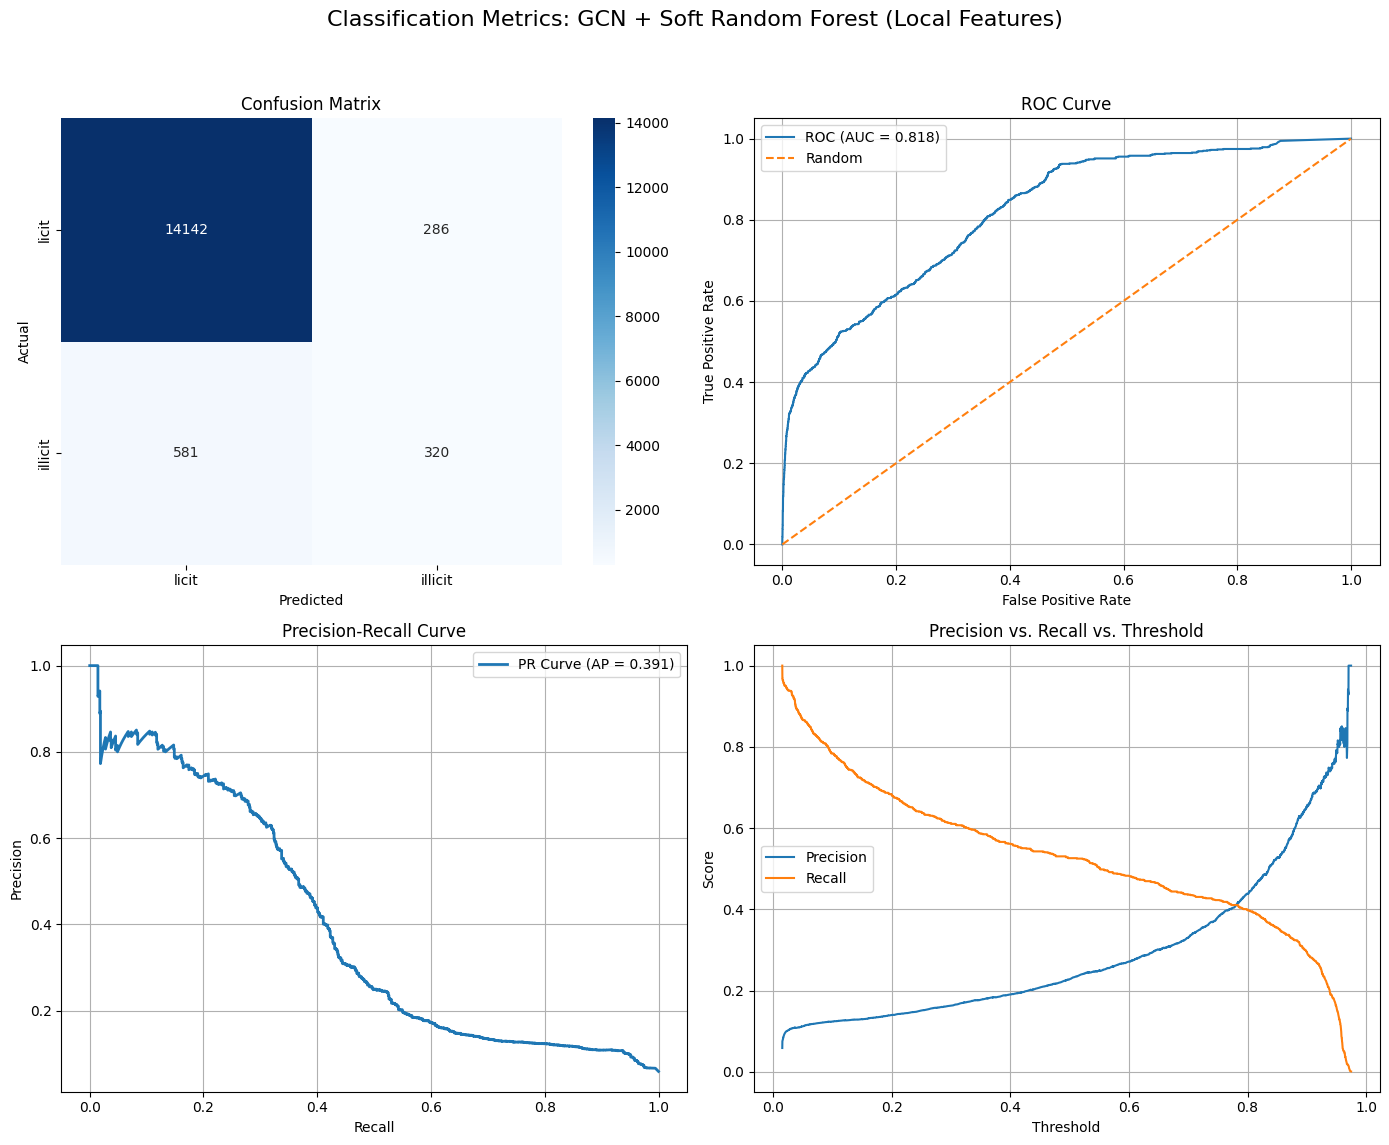

              precision    recall  f1-score   support

       licit       0.96      0.98      0.97     14428
     illicit       0.53      0.36      0.42       901

    accuracy                           0.94     15329
   macro avg       0.74      0.67      0.70     15329
weighted avg       0.94      0.94      0.94     15329

ROC AUC: 0.817992


In [ ]:
# Evaluate Final Model
final_metrics = evaluate(model_final, data, eval_mask=test_known_mask)
print("\nFinal Test Set Metrics:")
for k, v in final_metrics.items():
    print(f"{k}: {v:.4f}")

model_final.eval()
with torch.no_grad():
    logits = model_final(data)
    prob = F.softmax(logits, dim=1)[:, 1]

y_test = data.y[data.test_mask].cpu().numpy()
y_prob = prob[data.test_mask].cpu().numpy()
y_pred = (y_prob >= final_metrics['threshold']).astype(int)

plot_classification_results(y_test, y_prob, y_pred, 'GCN + Soft Random Forest (Local Features)')